## [2] A Convolutional Neural Network for Gender Recognition Optimizing the Accuracy/Speed Tradeoff
<img src="images/[2].png"> <br>
Document available at: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9139235

First we need to import used libraries:

In [1]:
import tensorflow as tf, pandas as pd, matplotlib.pyplot as plt, numpy as np, os
from keras.models import Model
from keras.layers import Conv2D, Dense, BatchNormalization, DepthwiseConv2D, ReLU, AvgPool2D, Input
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from helper.prepare_data import prepare_data

First, we pick the dataset that we would like to use from:
<br>1 - Age, gender, ethnicity CSV
<br>2 - UTKFace
<br>3 - Fairface

In [2]:
choice = 3

Prepare data from each dataset so that we end up with normalized pixels and labels:

In [9]:
x, y_age, y_gender, y_ethnicity, img_size = prepare_data(choice = choice)

Display some exemplary images:

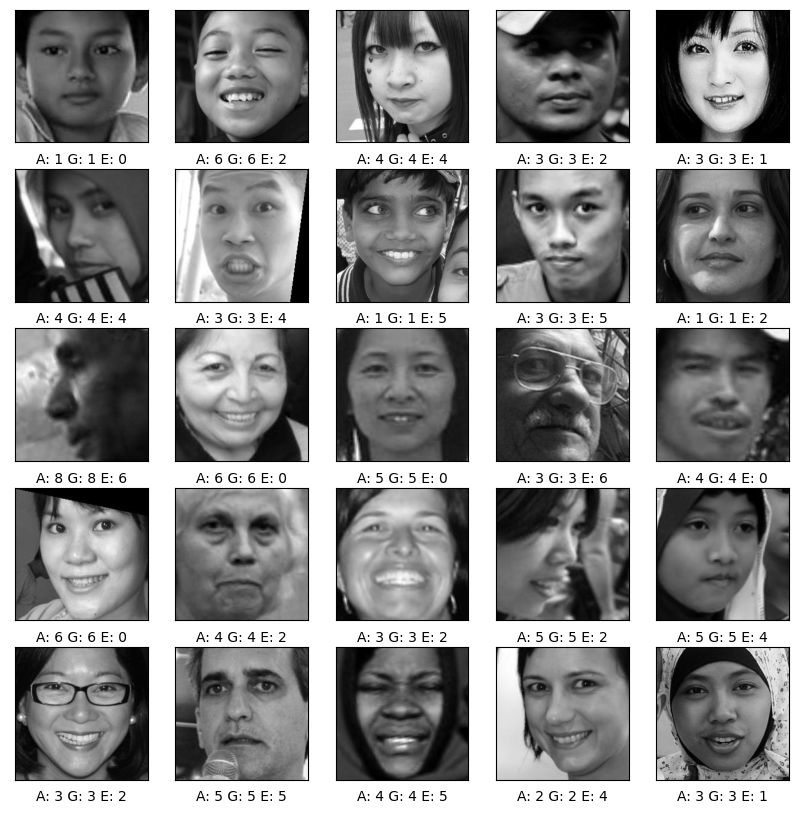

In [4]:
# size of the whole grid of images
plt.figure(figsize=(10, 10))

# display first 25 images in a 5x5 grid
for i in range(0, 25):
    plt.subplot(5, 5, (i % 25) + 1)
    plt.grid(False)
    #disable x and y axis description
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x[i].reshape(img_size, img_size), cmap='gray')
    # A = age, G = gender, E = ethnicity
    plt.xlabel("A: "+ str(y_age[i]) + " G: " + str(y_gender[i]) + (" E: " + str(y_ethnicity[i]) if y_ethnicity.size > 0 else ""))
plt.show()

MobileNet implementation:

In [5]:
def mobilnet_block(layer, filters, strides):
    
    layer = DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(layer)
    layer = BatchNormalization()(layer)
    layer = ReLU()(layer)
    
    layer = Conv2D(filters = filters, kernel_size = 1, strides = 1)(layer)
    layer = BatchNormalization()(layer)
    layer = ReLU()(layer)
    
    return layer

input = Input(shape = (img_size, img_size, 1))
layer = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)

layer = mobilnet_block(layer, filters = 64, strides = 1)
layer = mobilnet_block(layer, filters = 128, strides = 2)
layer = mobilnet_block(layer, filters = 128, strides = 1)
layer = mobilnet_block(layer, filters = 256, strides = 2)
layer = mobilnet_block(layer, filters = 256, strides = 1)
layer = mobilnet_block(layer, filters = 512, strides = 2)

for _ in range (5):
     layer = mobilnet_block(layer, filters = 512, strides = 1)

layer = mobilnet_block(layer, filters = 1024, strides = 2)
layer = mobilnet_block(layer, filters = 1024, strides = 1)

layer = AvgPool2D(pool_size = 7, strides = 1, data_format = 'channels_last') (layer)

output = Dense (units = 1000, activation = 'softmax')(layer)

model = Model(inputs = input, outputs = output)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy', 'mae'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 112, 112, 32)     320       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     128   

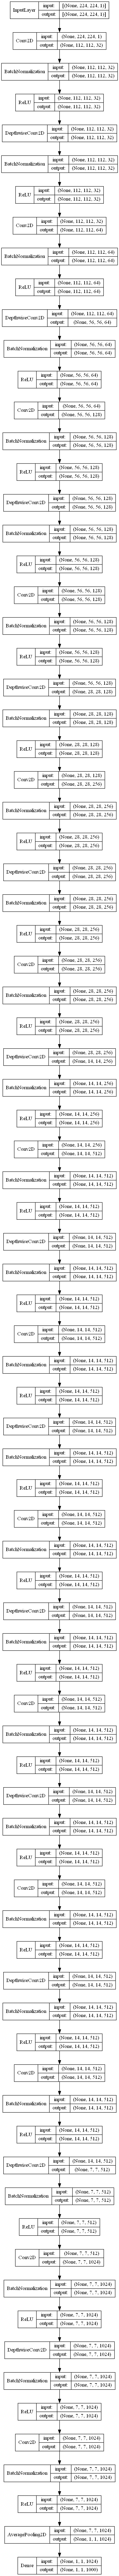

In [6]:
plot_model(model, to_file = os.getcwd() + '//images//[2]_model.png', show_shapes = True, show_dtype = False, show_layer_names = False, rankdir = 'TB', expand_nested = False, dpi = 96)

Training and validation:

In [7]:
history = model.fit(x, y_age , epochs = 10, validation_split = 0.2)
# 78m 12.8s for 10 epochs

Epoch 1/20
274/274 [==============================] - 510s 2s/step - loss: 2.0181 - accuracy: 0.2673 - val_loss: 2.0138 - val_accuracy: 0.3002
Epoch 2/20
274/274 [==============================] - 502s 2s/step - loss: 1.8992 - accuracy: 0.2827 - val_loss: 1.9660 - val_accuracy: 0.3002
Epoch 3/20
274/274 [==============================] - 489s 2s/step - loss: 1.8907 - accuracy: 0.2920 - val_loss: 1.9081 - val_accuracy: 0.3002
Epoch 4/20
274/274 [==============================] - 480s 2s/step - loss: 1.8874 - accuracy: 0.2904 - val_loss: 1.8954 - val_accuracy: 0.3002
Epoch 5/20
274/274 [==============================] - 481s 2s/step - loss: 1.8864 - accuracy: 0.2883 - val_loss: 1.9066 - val_accuracy: 0.3002
Epoch 6/20
274/274 [==============================] - 478s 2s/step - loss: 1.8819 - accuracy: 0.2891 - val_loss: 1.9049 - val_accuracy: 0.2104
Epoch 7/20
274/274 [==============================] - 483s 2s/step - loss: 1.8789 - accuracy: 0.2929 - val_loss: 1.8906 - val_accuracy: 0.3002

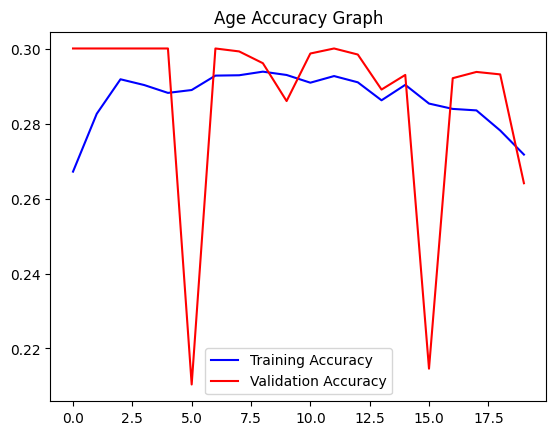

In [8]:
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Age Accuracy Graph')
plt.legend()